#### Importing required libraries

In [1]:
from PIL import Image
import numpy as np
from skimage.transform import resize
import scipy.sparse.linalg as ll
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math

#### Reading the input images and vectoring them

In [2]:
def read_img(path):
    """
    Function to Read image and store it as an array, given the image path. Returns the 2 dimensional image array.
    """
    img = Image.open(path)
    img_arr = np.array(img, dtype='float')
    img.close()
    return img_arr

In [3]:
def img_transform(img_type):
    '''
    This function reads the original images, downsamples them by a factor of 4,vectorizes the downsampled image arrays and returns the img_type requested
    img_type : Can take values Original,Downsampled,Vectorized
    '''
    
    #Reading the input image
    DATA_PATH = 'data/yalefaces'
    FILE_NAMES = ['subject01.glasses.gif','subject01.happy.gif','subject01.leftlight.gif','subject01.noglasses.gif','subject01.normal.gif','subject01.rightlight.gif','subject01.sad.gif','subject01.sleepy.gif','subject01.surprised.gif','subject01.wink.gif','subject02.glasses.gif','subject02.happy.gif','subject02.leftlight.gif','subject02.noglasses.gif','subject02.normal.gif','subject02.rightlight.gif','subject02.sad.gif','subject02.sleepy.gif','subject02.wink.gif','subject01-test.gif','subject02-test.gif']
    
    result = {}

    for img in FILE_NAMES:
        orig_img_arr = read_img(f"{DATA_PATH}/{img}")
        
        # Downsampling the image array by a factor of 4
        dwnsmp_img_arr = resize(orig_img_arr,(orig_img_arr.shape[0] // 4, orig_img_arr.shape[1] // 4),anti_aliasing=True)
        
        # Vectorizing the image
        size = dwnsmp_img_arr.shape[0] * dwnsmp_img_arr.shape[1]
        vector_img_arr = dwnsmp_img_arr.reshape(size).reshape(-1,1)
        
        if img_type == 'Original':
            result[img] = orig_img_arr
        elif img_type == 'Downsampled':
            result[img] = dwnsmp_img_arr
        elif img_type == 'Vectorized':
            result[img] = vector_img_arr
    return result

### Analysis of Images

Below steps were followed to solve this problem. First, all the given images were analyzed. There are 10 images of the first person (Subject 1) shot at different lighting and with different face expressions. There are 9 images of the second person (Subject 2) captured the same way as Subject 1. In addition, there are 2 test images, one for each person which will be used to perform face recognition.  


•	After importing all the images, as mentioned, the images are down-sampled by a factor of 4.  
•	After down-sampling, the images are vectorized (all pixels are represented by a column vector).

In [4]:
images_vectorized = img_transform('Vectorized')

# Creating a data matrix for Subject 1
# Each row in the matrix represents vectorized picture of each expression of Subject 1

subject1 = np.concatenate(([images_vectorized[key] for key,val in images_vectorized.items() if 'subject01' in key and 'subject01-test' not in key]),axis=1).T

# Creating a data matrix for Subject 2
# Each row in the matrix represents vectorized picture of each expression of Subject 2

subject2 = np.concatenate(([images_vectorized[key] for key,val in images_vectorized.items() if 'subject02' in key and 'subject02-test' not in key]),axis=1).T

print("Subject 1 matrix shape: ", subject1.shape)
print("Subject 2 matrix shape: ", subject2.shape)

Subject 1 matrix shape:  (10, 4800)
Subject 2 matrix shape:  (9, 4800)


#### Analysis of Subject 1

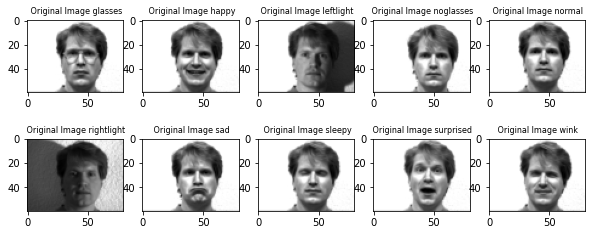

In [5]:
FILE_NAMES = ['subject01.glasses.gif','subject01.happy.gif','subject01.leftlight.gif','subject01.noglasses.gif','subject01.normal.gif','subject01.rightlight.gif','subject01.sad.gif','subject01.sleepy.gif','subject01.surprised.gif','subject01.wink.gif','subject02.glasses.gif','subject02.happy.gif','subject02.leftlight.gif','subject02.noglasses.gif','subject02.normal.gif','subject02.rightlight.gif','subject02.sad.gif','subject02.sleepy.gif','subject02.wink.gif','subject01-test.gif','subject02-test.gif']
## Original Images of Subject 1
fig = plt.figure(figsize=(10, 4))
columns = 5
rows = 2

images = {i+1:subject1[i,:].reshape(60,80) for i in range(columns*rows)}

for i in range(columns*rows):
    sp = fig.add_subplot(rows, columns, i+1)
    sp.set_title(f" Original Image {FILE_NAMES[i].split('.')[1]}", fontdict = {'fontsize':8})
    plt.imshow(images[i+1],cmap='gray')
plt.show() 

In [6]:
def pca(data_array, k):
    '''
    This function gets the input image data matrix and the number of components k. This performs the following:
    1) Creates the covariance matrix of the image data
    2) Performs Eigen decomposition of the Covariance Matrix
    3) Returns the leading k Eigen values/ Eigen Vectors after Eigen decomposition
    '''
    data = data_array
    m, n = data.shape
    mu = np.mean(data, axis = 0)
    xc = data - mu[None,:]
    
    C = np.dot(xc, xc.T)/n
    
    S, W = ll.eigs(C, k = k)
    S = S.real
    W = W.real
    
    return S, W, xc, C 

#### Steps to get Eigen Faces

•	The data matrix of subject 1 has the below dimensions
Subject 1 matrix shape: (10, 4800)

There are 10 images (as we can see above), and each image has 4800 pixels.   
•	To compute the eigen faces for Subject 1, we calculate the Covariance matrix of the image data based on the algorithm. This captures the variability of data along different directions (i.e the covariance between the different images of Subject 1 in this case).  
•	We can get the Eigen faces for Subject 1 by performing eigen decomposition on the covariance matrix calculated above. We will compute the leading 6 Eigen vectors for the covariance matrix, which will represent the 6 Eigen faces that we will analyze.  
•	After re-shaping the Eigen vectors, below are the top 6 Eigen faces for Subject 1 (1 being the first Eigen face).  

In [7]:
## Generating Eigen Faces for Subject 1
S1, W1, xc1, C1 = pca(subject1, 6)

In [8]:
dim1 = np.dot(W1[:,0].T,xc1)/math.sqrt(S1[0]) # extract 1st eigenvalues
dim2 = np.dot(W1[:,1].T,xc1)/math.sqrt(S1[1]) # extract 2nd eigenvalue
dim3 = np.dot(W1[:,2].T,xc1)/math.sqrt(S1[2]) # extract 3rd eigenvalues
dim4 = np.dot(W1[:,3].T,xc1)/math.sqrt(S1[3]) # extract 4th eigenvalue
dim5 = np.dot(W1[:,4].T,xc1)/math.sqrt(S1[4]) # extract 5th eigenvalues
dim6 = np.dot(W1[:,5].T,xc1)/math.sqrt(S1[5]) # extract 6th eigenvalue

## Reshaping the Eigen Faces for plotting
eigenface1_s1 = dim1.reshape(60,80)
eigenface2_s1 = dim2.reshape(60,80)
eigenface3_s1 = dim3.reshape(60,80)
eigenface4_s1 = dim4.reshape(60,80)
eigenface5_s1 = dim5.reshape(60,80)
eigenface6_s1 = dim6.reshape(60,80)

#### Plotting the First 6 Eigen faces For Subject 1 after Eigen Decomposition

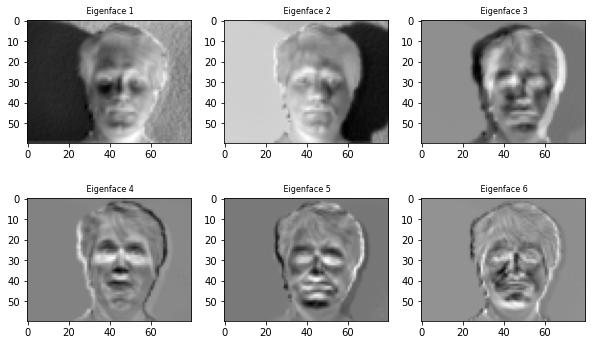

In [9]:
## Plotting the First 6 Eigen faces For Subject 1 after Eigen Decomposition
fig = plt.figure(figsize=(10, 6))
columns = 3
rows = 2

eigfaces = {1:eigenface1_s1, 2:eigenface2_s1, 3:eigenface3_s1, 4:eigenface4_s1, 5:eigenface5_s1, 6:eigenface6_s1}

for i in range(columns*rows):
    sp = fig.add_subplot(rows, columns, i+1)
    sp.set_title(f" Eigenface {i+1}", fontdict = {'fontsize':8})
    plt.imshow(eigfaces[i+1],cmap='gray')
plt.show() 

#### Interpretation of Eigen Faces

Interpretation of the Leading 6 Eigen Faces
We observe that the first and second components (eigen faces) are clearer than the other eigen faces. These capture most of the important features of input image, and we can interpret the direction of the most important feature by comparing them with the original image. We also see that while most important features of Subject 1(facial features) are captured in the first 2 Eigen faces, the remaining eigen faces capture direction of features that are not captured by the first 2 components (glasses/ facial expressions).  
Eigen Face 1: This Eigenface captures the most important linear combination of features from the "RightLight" Original image. You can see the facial features like eyes, nose, mouth etc and the light captured well.  

Eigen Face 2: This Eigenface captures the second most important features along the direction of the "LeftLight" Original image. You can see the facial features like eyes, nose mouth etc are captured well in this.  

Eigen Face 3: This Eigenface captures the direction of the features from the "Noglasses" Original Image, we can see that the eyes are not very clear in this image as this is captured in the first 2 eigen faces. This captures the No glasses feature, which is the area around the eyes.  

Eigen Face 4: This Eigenface captures the direction of the features from "Surprised" Original Image (the facial expression of surprise).  

Eigen Face 5: This Eigenface captures the direction of the features from "Wink" Original Image (the facial expression of winking eye)  

Eigen Face 6: This Eigenface captures the direction of the features from "Happy" Original Image(the facial expression of smile). However, this is the blurriest image of all since most of the important features are not part of this eigen vector.     

#### Representation of the mean of all 10 images

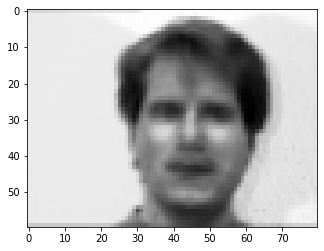

In [10]:
# Representation of the mean of all 10 images
mu1 = np.mean(subject1, axis=0)
plt.imshow(mu1.reshape(60,80), cmap="gray")

#### Analysis of Subject 2

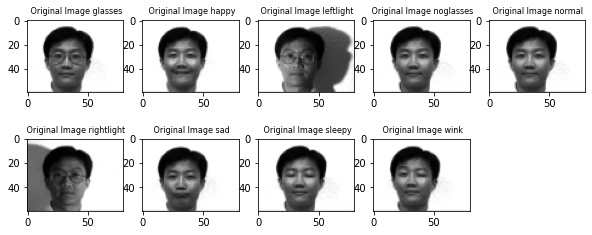

In [11]:
FILE_NAMES = ['subject01.glasses.gif','subject01.happy.gif','subject01.leftlight.gif','subject01.noglasses.gif','subject01.normal.gif','subject01.rightlight.gif','subject01.sad.gif','subject01.sleepy.gif','subject01.surprised.gif','subject01.wink.gif','subject02.glasses.gif','subject02.happy.gif','subject02.leftlight.gif','subject02.noglasses.gif','subject02.normal.gif','subject02.rightlight.gif','subject02.sad.gif','subject02.sleepy.gif','subject02.wink.gif','subject01-test.gif','subject02-test.gif']
## Original Images of Subject 2
fig = plt.figure(figsize=(10, 4))
columns = 5
rows = 2

images = {i+1:subject2[i,:].reshape(60,80) for i in range(9)}

for i in range(9):
    sp = fig.add_subplot(rows, columns, i+1)
    sp.set_title(f" Original Image {FILE_NAMES[i+10].split('.')[1]}", fontdict = {'fontsize':8})
    plt.imshow(images[i+1],cmap='gray')
plt.show() 

#### Analysis of Subject 2 

•	The data matrix of subject 1 has the below dimensions  
Subject 2 matrix shape: (9, 4800)  
There are 9 images (as we can see above), and each image has 4800 pixels.  
•	To compute the eigen faces for Subject 2, we calculate the Covariance matrix of the image data based on the algorithm. This captures the variability of data along different directions (i.e the covariance between the different images of Subject 2).  
•	We can get the Eigen faces for Subject 2 by performing eigen decomposition on the covariance matrix calculated above. We will compute the leading 6 Eigen vectors for the covariance matrix, which will represent the 6 Eigen faces that we will analyze.  
•	After re-shaping the Eigen vectors, below are the top 6 Eigen faces for Subject 2 (1 being the first Eigen face).  

In [12]:
## Generating Eigen Faces for Subject 2
S2, W2, xc2, C2 = pca(subject2, 6)

In [13]:
dim2_1 = np.dot(W2[:,0].T,xc2)/math.sqrt(S2[0]) # extract 1st eigenvalues
dim2_2 = np.dot(W2[:,1].T,xc2)/math.sqrt(S2[1]) # extract 2nd eigenvalue
dim2_3 = np.dot(W2[:,2].T,xc2)/math.sqrt(S2[2]) # extract 3rd eigenvalues
dim2_4 = np.dot(W2[:,3].T,xc2)/math.sqrt(S2[3]) # extract 4th eigenvalue
dim2_5 = np.dot(W2[:,4].T,xc2)/math.sqrt(S2[4]) # extract 5th eigenvalues
dim2_6 = np.dot(W2[:,5].T,xc2)/math.sqrt(S2[5]) # extract 6th eigenvalue

In [14]:
eigenface1_s2 = dim2_1.reshape(60,80)
eigenface2_s2 = dim2_2.reshape(60,80)
eigenface3_s2 = dim2_3.reshape(60,80)
eigenface4_s2 = dim2_4.reshape(60,80)
eigenface5_s2 = dim2_5.reshape(60,80)
eigenface6_s2 = dim2_6.reshape(60,80)

#### Plotting the First 6 Eigen faces For Subject 2 after Eigen Decomposition

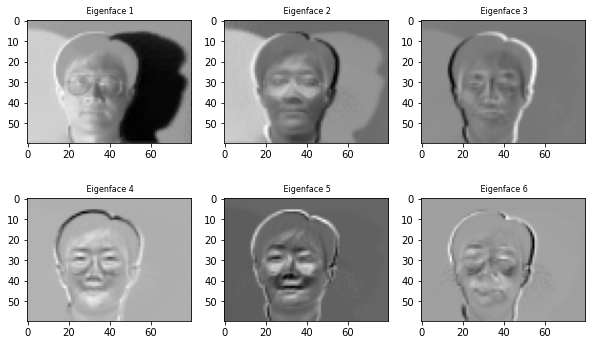

In [15]:
## Plotting the First 6 Eigen faces For Subject 2 after Eigen Decomposition
fig2 = plt.figure(figsize=(10, 6))
columns = 3
rows = 2

eigfaces2 = {1:eigenface1_s2, 2:eigenface2_s2, 3:eigenface3_s2, 4:eigenface4_s2, 5:eigenface5_s2, 6:eigenface6_s2}

for i in range(columns*rows):
    sp = fig2.add_subplot(rows, columns, i+1)
    sp.set_title(f" Eigenface {i+1}", fontdict = {'fontsize':8})
    plt.imshow(eigfaces2[i+1],cmap='gray')
plt.show() 

#### Interpretation of Eigen Faces

Interpretation of the Leading 6 Eigen Faces  
We observe that the first and second components (eigen faces) are clearer than the other eigen faces. These capture most of the important features of input image, and we can interpret the direction of the most important feature by comparing them with the original image. We also see that while most important features of Subject 2(facial features) are captured in the first 2 Eigen faces, the remaining eigen faces capture direction of features that are not captured by the first 2 components (facial expressions).  
Eigen Face 1: This Eigenface captures the most important linear combination of features from the "Left Light" Original image. You can see the facial features like nose, mouth, light direction etc. are captured well in this.  

Eigen Face 2: This Eigenface captures the second most important features from the " RightLight" Original image. You can see the facial features like nose mouth etc are captured well in this.  

Eigen Face 3: This Eigenface captures the direction of the features from the "Noglasses" Original Image, we can see that the eyes are not very clear in this image as this is captured in the first 2 eigen faces. This captures the No glasses feature predominantly.  

Eigen Face 4: This Eigenface captures the direction of the features from "Glasses" Original Image (we can identify the glasses and eyes in this).  

Eigen Face 5: This Eigenface captures the direction of the features from " Wink" Original Image (the facial expression)  

Eigen Face 6: This Eigenface captures the direction of the features from "Happy" Original Image(the facial expression of smile). However, this is the blurriest image of all since most of the important features are not part of this eigen vector.  


### Classification of Images from a test set

For this, the two test images were imported, down-sampled and vectorized the same way as the other images. After this, we will calculate the projection residual of the 2 test images with the vectorized eigen faces based on the formula provided. Since the eigen vectors are shifted to a new space, when we calculate the covariance matrix and subtract by the data mean, I have applied the same to the test images and standardized the same so that the test image data is in the same range of the eigen faces that they are being compared to.

In [16]:
## Reading the test images, down-sampling and vectoring them
sub1_test_vector_img = images_vectorized['subject01-test.gif']
sub2_test_vector_img = images_vectorized['subject02-test.gif']

## Calculating the mean and Standard deviations of the Main image array to be used in the calculations below
mu1 = np.mean(subject1.T, axis=1)
std1 = np.std(subject1)
mu2 = np.mean(subject2.T, axis=1)
std2 = np.std(subject2)

## Renaming the top 1 eigen vectors for Subject 1 and Subject 2
top_eigface_sub1 = dim1.reshape(-1,1)
top_eigface_sub2 = dim2_1.reshape(-1,1)

#### Visualizing the images used for testing

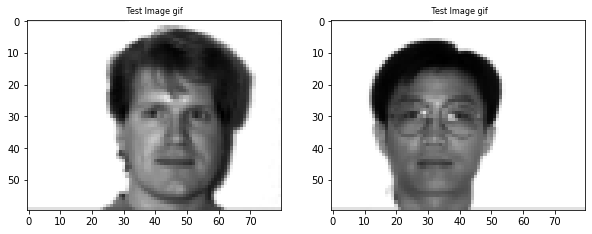

In [17]:
FILE_NAMES = ['subject01-test.gif','subject02-test.gif']
## Original Test Images
fig = plt.figure(figsize=(10, 4))
columns = 2
rows = 1

images = {1:sub1_test_vector_img.reshape(60,80), 2:sub2_test_vector_img.reshape(60,80)}

for i in range(2):
    sp = fig.add_subplot(rows, columns, i+1)
    sp.set_title(f" Test Image {FILE_NAMES[i].split('.')[1]}", fontdict = {'fontsize':8})
    plt.imshow(images[i+1],cmap='gray')
plt.show() 

#### Calculating the projection residuals  

s11 : Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 1  
s21 : Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 2  
s12 : Projection residual of Test Image of Subject 2 with the first Eigen face of Subject 1  
s22 : Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 2

In [18]:
# Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 1
s11 = np.linalg.norm(((sub1_test_vector_img - mu1.reshape(-1,1))/std1) - np.dot(top_eigface_sub1, np.dot(top_eigface_sub1.T, ((sub1_test_vector_img - mu1.reshape(-1,1))/std1))),ord=2)**2
print(s11)
# Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 2
s21 = np.linalg.norm(((sub1_test_vector_img - mu2.reshape(-1,1))/std2) - np.dot(top_eigface_sub2, np.dot(top_eigface_sub2.T, ((sub1_test_vector_img - mu2.reshape(-1,1))/std2))),ord=2)**2
print(s21)
# Projection residual of Test Image of Subject 2 with the first Eigen face of Subject 1
s12 = np.linalg.norm(((sub2_test_vector_img - mu1.reshape(-1,1))/std1) - np.dot(top_eigface_sub1, np.dot(top_eigface_sub1.T, ((sub2_test_vector_img - mu1.reshape(-1,1))/std1))),ord=2)**2
print(s12)
# Projection residual of Test Image of Subject 1 with the first Eigen face of Subject 2
s22 = np.linalg.norm(((sub2_test_vector_img - mu2.reshape(-1,1))/std2) - np.dot(top_eigface_sub2, np.dot(top_eigface_sub2.T, ((sub2_test_vector_img - mu2.reshape(-1,1))/std2))),ord=2)**2
print(s22)

456810484.8157536
39597766887.267166
10607273834.12047
2261626105.6724176


In [19]:
s = np.array([[s11, s21],[s12,s22]])
print("Projection Residual scores are: ")
print(s)

Projection Residual scores are: 
[[4.56810485e+08 3.95977669e+10]
 [1.06072738e+10 2.26162611e+09]]


#### Classification results

From these residuals, we can identify the lowest scores for each subject’s test images respectively. As learnt in the lecture, when we performed Eigen decomposition with multiple training images for each subject, we extracted 6 components, which captured the direction of the most important features from the original 10 images.  
When a test image is projected with the top eigen face, if the test image is of the same subject as the eigen face, the features will be in the same direction with some changes due to the compression, which is shown as the residual.   
If the test image if of a different subject from the eigen face, then the features will be in different directions which will give a larger residual since they are completely different.   

We can use this residual to classify the test image as Subject 1 or Subject 2. As we can see, the residual for Subject 1 when projected with Eigen face of subject 1 is 456810484.82, however when projected with the eigen face of subject 2 – it is 39597766887.27. We can classify Test Image 1 as Subject 1 since it has a lower residual which is more along the same direction as Eigen face of subject 1. Similarly, the residual for Subject 2 when projected with Eigen face of subject 1 is 10607273834.12, however when projected with the eigen face of subject 1 – it is 2261626105.67. We can classify Test 2 as Subject 2 since it has a lower residual which is more along the same direction as Eigen face of subject 2.


#### THE END